[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dữ liệu ban đầu:
                                                 sms  label
0  Go until jurong point, crazy.. Available only ...      0
1                    Ok lar... Joking wif u oni...\n      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0

Dữ liệu sau khi làm sạch:
                                                 sms  \
0  Go until jurong point, crazy.. Available only ...   
1                    Ok lar... Joking wif u oni...\n   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                             Cleaned  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u 

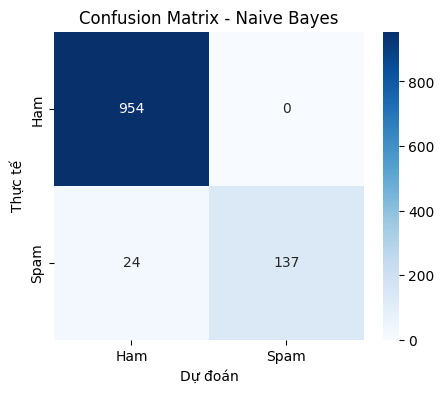

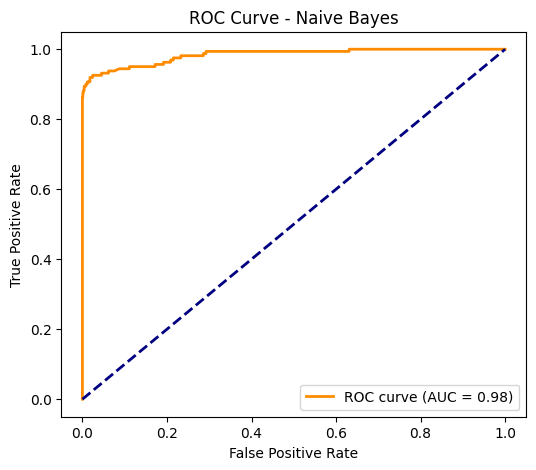

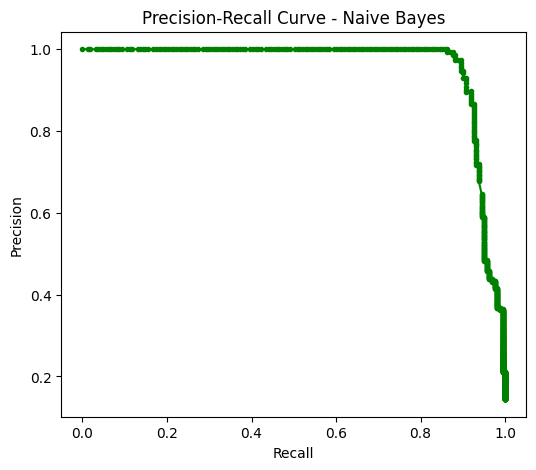


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       954
           1       0.97      0.76      0.85       161

    accuracy                           0.96      1115
   macro avg       0.97      0.88      0.92      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
 [[950   4]
 [ 38 123]]


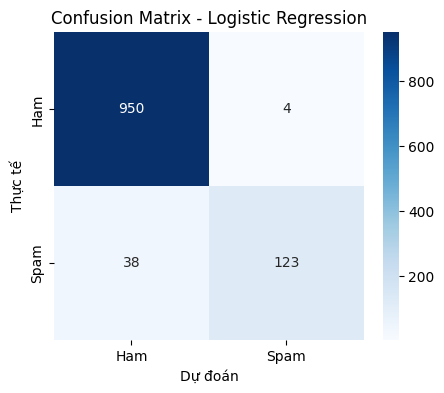

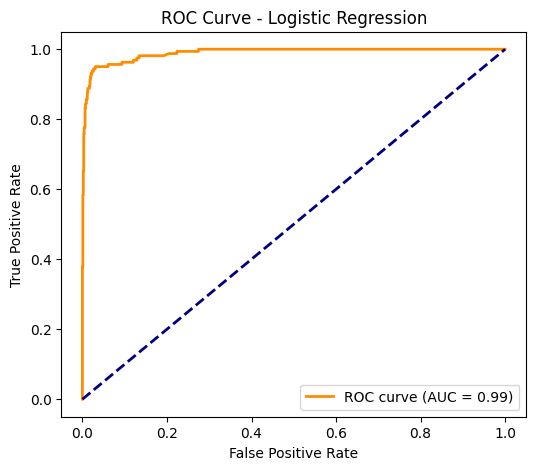

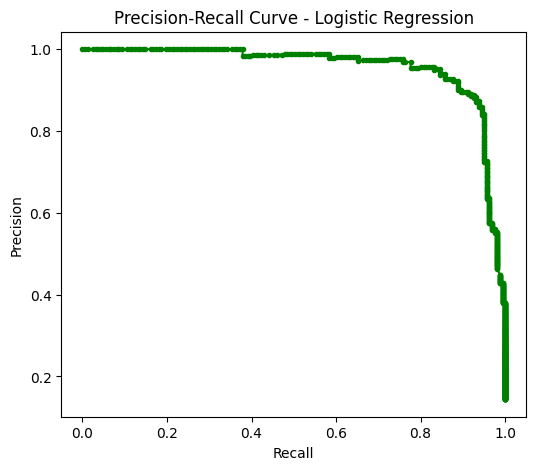


===== SVM =====
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       0.98      0.89      0.94       161

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
 [[951   3]
 [ 17 144]]


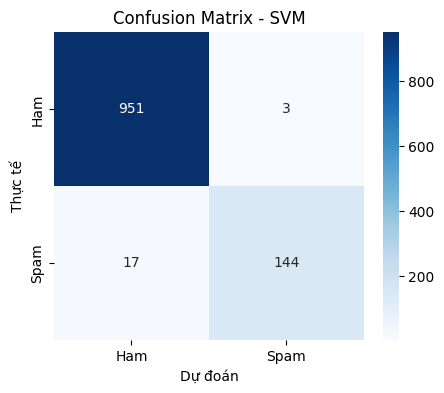

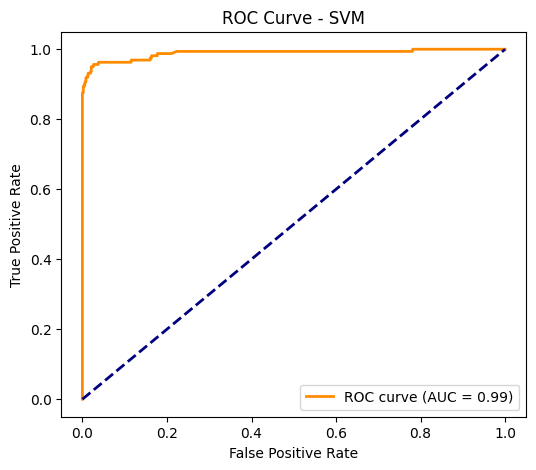

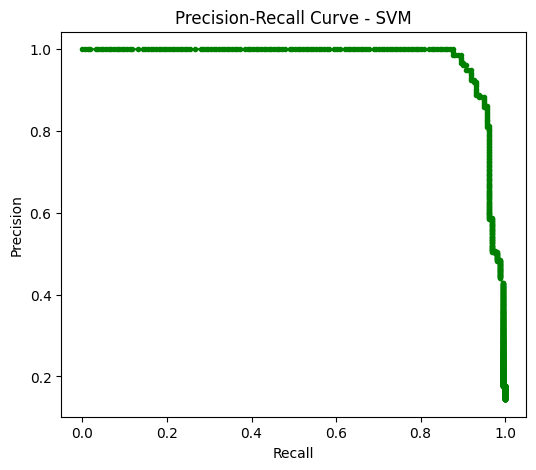


===== Decision Tree =====
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       954
           1       0.83      0.84      0.83       161

    accuracy                           0.95      1115
   macro avg       0.90      0.90      0.90      1115
weighted avg       0.95      0.95      0.95      1115

Confusion Matrix:
 [[926  28]
 [ 26 135]]


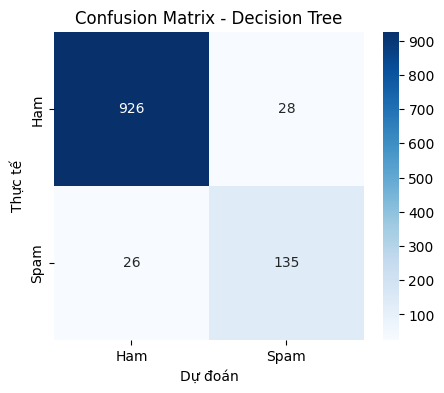

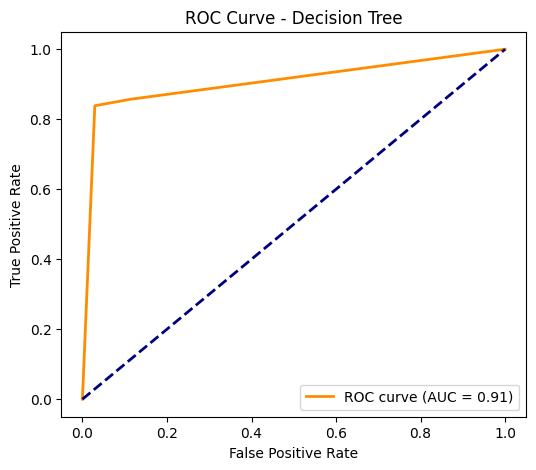

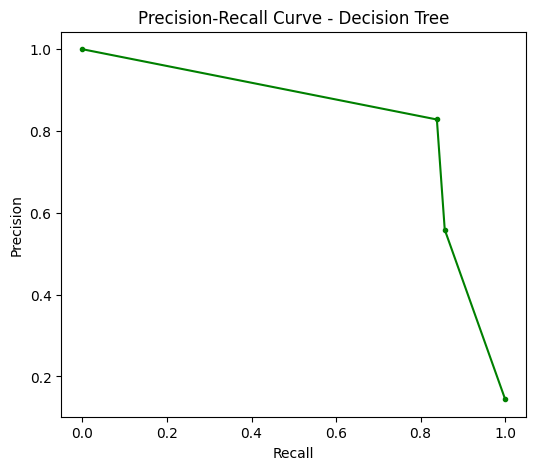

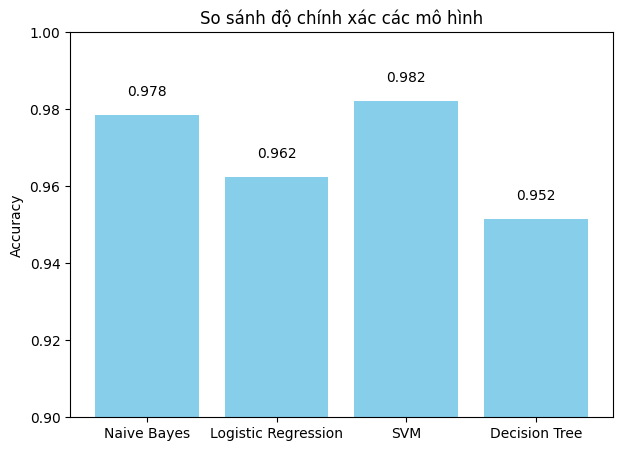

In [3]:
# 1. Import thư viện
import pandas as pd
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Tải stopwords tiếng Anh
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# 2. Đọc dữ liệu
df = pd.read_csv("/content/drive/MyDrive/train.csv")
print("Dữ liệu ban đầu:")
print(df.head())

# 3. Hàm làm sạch văn bản
def clean_text(text):
    text = str(text).lower()                              # chữ thường
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # bỏ URL
    text = re.sub(r"\d+", "", text)                      # bỏ số
    text = text.translate(str.maketrans("", "", string.punctuation)) # bỏ dấu câu
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]     # bỏ stopwords
    return " ".join(tokens)

df["Cleaned"] = df["sms"].apply(clean_text)

print("\nDữ liệu sau khi làm sạch:")
print(df[["sms","Cleaned"]].head())

# 4. Chuyển hóa dữ liệu (TF-IDF)
X = df["Cleaned"]
y = df["label"]

vectorizer = TfidfVectorizer(max_features=3000)
X_vec = vectorizer.fit_transform(X)

# 5. Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# 6. Huấn luyện và đánh giá các mô hình
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}   # Lưu accuracy

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # In báo cáo
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # ===== 1. Vẽ Confusion Matrix heatmap =====
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Ham","Spam"],
                yticklabels=["Ham","Spam"])
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ===== 2. Vẽ ROC Curve & Precision-Recall Curve (nếu có) =====
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None

    if y_prob is not None:
        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, color="darkorange", lw=2,
                 label="ROC curve (AUC = %0.2f)" % roc_auc)
        plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, marker=".", color="green")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve - {name}")
        plt.show()

# ===== 3. Vẽ biểu đồ so sánh accuracy giữa các mô hình =====
plt.figure(figsize=(7,5))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.ylabel("Accuracy")
plt.title("So sánh độ chính xác các mô hình")
plt.ylim(0.9,1.0)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center')
plt.show()
